In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

from sklearn.model_selection import KFold

In [2]:
with xr.open_dataset("../cpcb_17_to_23.nc") as ds:
    pass
ds

<xarray.Dataset>
Dimensions:      (time: 61344, station: 65)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-01T00:30:00 ... 2023-12-31T23:...
  * station      (station) object 'Alipur_Delhi_DPCC' ... 'Wazirpur_Delhi_DPCC'
    lat          (station) float64 ...
    lon          (station) float64 ...
    elevation    (station) float64 ...
    pop_1km      (station) float64 ...
    pop_2km      (station) float64 ...
    pop_3km      (station) float64 ...
Data variables: (12/24)
    PM2.5        (time, station) float64 ...
    PM10         (time, station) float64 ...
    NO           (time, station) float64 ...
    NO2          (time, station) float64 ...
    NOx          (time, station) float64 ...
    NH3          (time, station) float64 ...
    ...           ...
    WD           (time, station) float64 ...
    RF           (time, station) float64 ...
    TOT-RF       (time, station) float64 ...
    SR           (time, station) float64 ...
    BP           (time, station) float64 ...
    VWS          (time, station) float64 ...

In [3]:
ds['PM2.5'].resample(time='Y').mean().isnull().sum(dim='station').to_dataframe()

,PM2.5
time,
2017-12-31,42
2018-12-31,18
2019-12-31,8
2020-12-31,2
2021-12-31,1
2022-12-31,0
2023-12-31,1


From 2020 data seems good. Now, we check monthly.

In [4]:
ds['PM2.5'].sel(time=slice('2020','2023')).resample(time='M').mean().isnull().sum(dim='station').to_dataframe()

,PM2.5
time,
2020-01-31,9
2020-02-29,10
2020-03-31,5
2020-04-30,5
2020-05-31,6
2020-06-30,5
2020-07-31,4
2020-08-31,4
2020-09-30,4


In [5]:
print("2020")
for month in range(7, 13):
    tmp_ds = ds['PM2.5'].sel(time='2020-'+str(month).zfill(2)).resample(time='M').mean().isnull().squeeze()
    print(month, tmp_ds[tmp_ds].station.values.tolist())

print("\n2021")
for month in range(1, 13):
    tmp_ds = ds['PM2.5'].sel(time='2021-'+str(month).zfill(2)).resample(time='M').mean().isnull().squeeze()
    print(month, tmp_ds[tmp_ds].station.values.tolist())
    
print("\n2022")
for month in range(1, 13):
    tmp_ds = ds['PM2.5'].sel(time='2022-'+str(month).zfill(2)).resample(time='M').mean().isnull().squeeze()
    print(month, tmp_ds[tmp_ds].station.values.tolist())
    
print("\n2023")
for month in range(1, 13):
    tmp_ds = ds['PM2.5'].sel(time='2023-'+str(month).zfill(2)).resample(time='M').mean().isnull().squeeze()
    print(month, tmp_ds[tmp_ds].station.values.tolist())

2020
7 ['Burari_Crossing_Delhi_IMD', 'Chandni_Chowk_Delhi_IITM', 'Lodhi_Road_Delhi_IITM', 'Sardar_Patel_Inter_College_Baghpat_UPPCB']
8 ['Burari_Crossing_Delhi_IMD', 'Chandni_Chowk_Delhi_IITM', 'Lodhi_Road_Delhi_IITM', 'Sardar_Patel_Inter_College_Baghpat_UPPCB']
9 ['Burari_Crossing_Delhi_IMD', 'Chandni_Chowk_Delhi_IITM', 'Lodhi_Road_Delhi_IITM', 'Sardar_Patel_Inter_College_Baghpat_UPPCB']
10 ['Burari_Crossing_Delhi_IMD', 'Chandni_Chowk_Delhi_IITM', 'Lodhi_Road_Delhi_IITM', 'Sardar_Patel_Inter_College_Baghpat_UPPCB']
11 ['Burari_Crossing_Delhi_IMD', 'Sardar_Patel_Inter_College_Baghpat_UPPCB']
12 ['Burari_Crossing_Delhi_IMD', 'Sardar_Patel_Inter_College_Baghpat_UPPCB']

2021
1 ['Burari_Crossing_Delhi_IMD', 'Narela_Delhi_DPCC', 'Sardar_Patel_Inter_College_Baghpat_UPPCB', 'Sector_11_Faridabad_HSPCB']
2 ['Burari_Crossing_Delhi_IMD', 'Narela_Delhi_DPCC', 'Sardar_Patel_Inter_College_Baghpat_UPPCB']
3 ['Burari_Crossing_Delhi_IMD', 'Sardar_Patel_Inter_College_Baghpat_UPPCB']
4 ['Burari_Crossing

In [6]:
missing_df = ds[['PM2.5', 'CO']].sel(time=slice('2022', '2023')).isnull().mean(dim='time').to_dataframe().sort_values('PM2.5', ascending=False).head(16)
missing_df

,PM2.5,CO,lat,lon,elevation,pop_1km,pop_2km,pop_3km
station,,,,,,,,
New_Collectorate_Baghpat_UPPCB,0.957477,0.960959,28.974801,77.213357,235.851746,3485.0,11088.0,19118.0
Lodhi_Road_Delhi_IITM,0.688984,0.843664,28.588333,77.221667,232.633987,69984.0,202022.0,512062.0
Chandni_Chowk_Delhi_IITM,0.606164,0.619863,28.656756,77.227234,242.798279,99175.0,555126.0,969081.0
Murthal_Sonipat_HSPCB,0.316495,0.375970,29.027200,77.062100,236.980927,3109.0,15336.0,28861.0
Sector_16A_Faridabad_HSPCB,0.277740,0.520947,28.408842,77.309908,225.533722,56423.0,243838.0,463028.0
Sardar_Patel_Inter_College_Baghpat_UPPCB,0.240753,0.314612,28.964949,77.278761,245.757690,2999.0,32177.0,55897.0
Vikas_Sadan_Gurugram_HSPCB,0.236016,0.224087,28.450124,77.026305,245.607208,54325.0,203621.0,374025.0
Burari_Crossing_Delhi_IMD,0.222888,0.104566,28.725650,77.201157,225.292328,9881.0,122118.0,314713.0
Sector_30_Faridabad_HSPCB,0.204795,0.188242,28.441700,77.321700,224.178101,18856.0,105891.0,224637.0


In [7]:
clean_ds = ds.sel(station=~ds.station.isin(missing_df.index))
# print(clean_ds)
freq = "M"
# print("2020")
# for month in range(7, 13):
#     tmp_ds = clean_ds['PM2.5'].sel(time='2020-'+str(month).zfill(2)).resample(time=freq).mean().isnull().squeeze()
#     print(month, tmp_ds[tmp_ds].station.values.tolist())

# print("\n2021")
# for month in range(1, 13):
#     tmp_ds = clean_ds['PM2.5'].sel(time='2021-'+str(month).zfill(2)).resample(time=freq).mean().isnull().squeeze()
#     print(month, tmp_ds[tmp_ds].station.values.tolist())
    
print("\n2022")
for month in range(1, 13):
    tmp_ds = clean_ds['PM2.5'].sel(time='2022-'+str(month).zfill(2)).resample(time=freq).mean().isnull().squeeze()
    print(month, tmp_ds[tmp_ds].station.values.tolist())
    
print("\n2023")
for month in range(1, 13):
    tmp_ds = clean_ds['PM2.5'].sel(time='2023-'+str(month).zfill(2)).resample(time=freq).mean().isnull().squeeze()
    print(month, tmp_ds[tmp_ds].station.values.tolist())


2022
1 []
2 []
3 []
4 []
5 []
6 []
7 []
8 []
9 []
10 []
11 []
12 []

2023
1 []
2 []
3 []
4 []
5 []
6 []
7 []
8 []
9 []
10 []
11 []
12 []


In [8]:
final_ds = clean_ds.sel(time=slice('2022', '2023'))
missing = final_ds['PM2.5'].isnull()
print(missing.sum())
# fill data with linear interpolation over time
final_ds['PM2.5'] = final_ds['PM2.5'].interpolate_na(dim='time', method='linear', fill_value="extrapolate")
print(final_ds['PM2.5'].isnull().sum())
final_ds["PM2.5_missing"] = missing
final_ds

<xarray.DataArray 'PM2.5' ()>
array(39894)
<xarray.DataArray 'PM2.5' ()>
array(0)


<xarray.Dataset>
Dimensions:        (time: 17520, station: 49)
Coordinates:
  * time           (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-12-31T2...
  * station        (station) object 'Alipur_Delhi_DPCC' ... 'Wazirpur_Delhi_D...
    lat            (station) float64 28.82 28.65 28.67 28.7 ... 28.66 28.67 28.7
    lon            (station) float64 77.15 77.32 76.93 ... 77.36 77.32 77.17
    elevation      (station) float64 232.7 228.1 235.9 ... 224.5 227.6 236.9
    pop_1km        (station) float64 5.191e+03 1.125e+05 ... 1.575e+05 1.543e+05
    pop_2km        (station) float64 2.459e+04 3.452e+05 ... 4.835e+05 5.677e+05
    pop_3km        (station) float64 5.667e+04 9.286e+05 ... 1.226e+06 1.084e+06
Data variables: (12/25)
    PM2.5          (time, station) float64 219.5 613.2 135.1 ... 207.8 213.8
    PM10           (time, station) float64 ...
    NO             (time, station) float64 ...
    NO2            (time, station) float64 ...
    NOx            (time, station) float64 ...
    NH3            (time, station) float64 ...
    ...             ...
    RF             (time, station) float64 ...
    TOT-RF         (time, station) float64 ...
    SR             (time, station) float64 ...
    BP             (time, station) float64 ...
    VWS            (time, station) float64 ...
    PM2.5_missing  (time, station) bool False False False ... False False False

## Add WRF-CAMX meteorological data

In [9]:
from aqmsp_data.preprocessing import preprocess_camxmet2d, preprocess_camxmet3d

In [10]:
files = glob("/home/patel_zeel/sarath_auto_download/data/camxmet2d.delhi.2023*.nc")
print(len(files))

def process(file):
    ds_2d = xr.open_dataset(file)
    ds_3d = xr.open_dataset(file.replace("camxmet2d", "camxmet3d"))
    
    ds_2d = preprocess_camxmet2d(ds_2d)
    ds_3d = preprocess_camxmet3d(ds_3d)
    return xr.merge([ds_2d, ds_3d])

processed_files = Parallel(n_jobs=8)(delayed(process)(file) for file in tqdm(files))
metds = xr.concat(processed_files, dim='time').sortby('time').sel(time=slice('2023'))
metds

167


  0%|          | 0/167 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:          (time: 4003, lat: 80, lon: 80)
Coordinates:
  * lat              (lat) float64 28.2 28.21 28.22 28.23 ... 28.97 28.98 28.99
  * lon              (lon) float64 76.85 76.86 76.87 76.88 ... 77.62 77.63 77.64
  * time             (time) datetime64[ns] 2023-07-17T05:30:00 ... 2023-12-31...
Data variables: (12/32)
    TSURF_K          (time, lat, lon) float32 302.3 302.3 302.3 ... 282.0 285.8
    SNOWEW_M         (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SNOWAGE_HR       (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    PRATE_MMpH       (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CLOUD_OD         (time, lat, lon) float32 62.24 61.67 61.1 ... 0.0 0.0 0.0
    U10_MpS          (time, lat, lon) float32 1.63 1.585 1.54 ... 1.443 1.227
    ...               ...
    UWIND_MpS_LAY0   (time, lat, lon) float32 1.584 1.539 1.494 ... 1.36 1.161
    UWIND_MpS_LAY19  (time, lat, lon) float32 0.5883 0.6261 ... 1.43 1.453
    UWIND_MpS_3d     (time, lat, lon) float32 0.8338 0.7744 ... -0.2445 -0.2575
    VWIND_MpS_LAY0   (time, lat, lon) float32 0.1718 0.1817 ... 0.0536 0.013
    VWIND_MpS_LAY19  (time, lat, lon) float32 -0.9759 -1.04 ... 0.4541 0.4684
    VWIND_MpS_3d     (time, lat, lon) float32 -0.5615 -0.5592 ... 0.2793 0.2947
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023264
    CTIME:          73659
    WDATE:          2023264
    ...             ...
    VGLVLS:         [0. 0.]
    GDNAM:          ????????????????
    UPNAM:          CAMx2IOAPI      
    VAR-LIST:       TSURF_K         SNOWEW_M        SNOWAGE_HR      PRATE_MMp...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY:

In [11]:
met_for_stations = []
for station in final_ds.station:
    lat = station.lat.item()
    lon = station.lon.item()
    # print(lat, lon)
    tmp_ds = metds.sel(lat=lat, lon=lon, method='nearest')
    tmp_ds['lat'] = lat
    tmp_ds['lon'] = lon
    # add station dimension to all variables
    tmp_ds.coords['station'] = station
    tmp_ds = tmp_ds.expand_dims('station', axis=1)
    met_for_stations.append(tmp_ds)
    
metds_for_stations = xr.concat(met_for_stations, dim='station')
merged_ds = xr.merge([metds_for_stations, final_ds]).sortby('time')
merged_ds = merged_ds.sel(time=slice('2023-07-17 05:30:00', '2023-12-31 23:30:00'))
merged_ds

<xarray.Dataset>
Dimensions:          (time: 4027, station: 49)
Coordinates:
  * time             (time) datetime64[ns] 2023-07-17T05:30:00 ... 2023-12-31...
  * station          (station) <U45 'Alipur_Delhi_DPCC' ... 'Wazirpur_Delhi_D...
    lat              (station) float64 28.82 28.65 28.67 ... 28.66 28.67 28.7
    lon              (station) float64 77.15 77.32 76.93 ... 77.36 77.32 77.17
    elevation        (station) float64 232.7 228.1 235.9 ... 224.5 227.6 236.9
    pop_1km          (station) float64 5.191e+03 1.125e+05 ... 1.543e+05
    pop_2km          (station) float64 2.459e+04 3.452e+05 ... 5.677e+05
    pop_3km          (station) float64 5.667e+04 9.286e+05 ... 1.084e+06
Data variables: (12/57)
    TSURF_K          (time, station) float32 302.7 304.3 303.5 ... 289.1 289.0
    SNOWEW_M         (time, station) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SNOWAGE_HR       (time, station) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PRATE_MMpH       (time, station) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    CLOUD_OD         (time, station) float32 51.14 42.13 51.18 ... 0.0 0.0 0.0
    U10_MpS          (time, station) float32 -1.029 -1.621 ... 1.105 0.7293
    ...               ...
    RF               (time, station) float64 ...
    TOT-RF           (time, station) float64 ...
    SR               (time, station) float64 ...
    BP               (time, station) float64 ...
    VWS              (time, station) float64 ...
    PM2.5_missing    (time, station) bool True True False ... False False False
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023264
    CTIME:          73659
    WDATE:          2023264
    ...             ...
    VGLVLS:         [0. 0.]
    GDNAM:          ????????????????
    UPNAM:          CAMx2IOAPI      
    VAR-LIST:       TSURF_K         SNOWEW_M        SNOWAGE_HR      PRATE_MMp...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY:

## Remove stations outside the range

RIICO_Ind._Area_III_Bhiwadi_RSPCB 76.862296 28.194909
Shyam_Nagar_Palwal_HSPCB 77.3320667 28.1485564


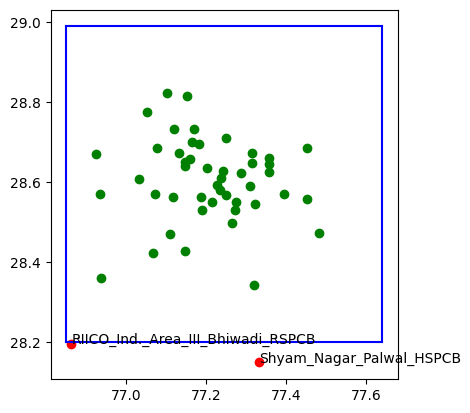

In [12]:
for station in merged_ds.station:
    lat = station.lat.item()
    lon = station.lon.item()
    if (lat > metds.lat.min()) and (lat < metds.lat.max()) and (lon > metds.lon.min()) and (lon < metds.lon.max()):
        plt.scatter(lon, lat, color='g')
    else:
        plt.scatter(lon, lat, color='r')
        plt.annotate(station.item(), (lon, lat))
        print(station.item(), lon, lat)

# draw a rectangle around the met domain
plt.plot([metds.lon.min(), metds.lon.min()], [metds.lat.min(), metds.lat.max()], color='b')
plt.plot([metds.lon.max(), metds.lon.max()], [metds.lat.min(), metds.lat.max()], color='b')
plt.plot([metds.lon.min(), metds.lon.max()], [metds.lat.min(), metds.lat.min()], color='b')
plt.plot([metds.lon.min(), metds.lon.max()], [metds.lat.max(), metds.lat.max()], color='b')
plt.gca().set_aspect('equal', adjustable='box')

In [13]:
stations = merged_ds.station.values.tolist()
stations.remove('Shyam_Nagar_Palwal_HSPCB')
stations.remove('RIICO_Ind._Area_III_Bhiwadi_RSPCB')
print(len(stations))
met_and_aq_ds = merged_ds.sel(station=stations)
met_and_aq_ds

47


<xarray.Dataset>
Dimensions:          (time: 4027, station: 47)
Coordinates:
  * time             (time) datetime64[ns] 2023-07-17T05:30:00 ... 2023-12-31...
  * station          (station) <U45 'Alipur_Delhi_DPCC' ... 'Wazirpur_Delhi_D...
    lat              (station) float64 28.82 28.65 28.67 ... 28.66 28.67 28.7
    lon              (station) float64 77.15 77.32 76.93 ... 77.36 77.32 77.17
    elevation        (station) float64 232.7 228.1 235.9 ... 224.5 227.6 236.9
    pop_1km          (station) float64 5.191e+03 1.125e+05 ... 1.543e+05
    pop_2km          (station) float64 2.459e+04 3.452e+05 ... 5.677e+05
    pop_3km          (station) float64 5.667e+04 9.286e+05 ... 1.084e+06
Data variables: (12/57)
    TSURF_K          (time, station) float32 302.7 304.3 303.5 ... 289.1 289.0
    SNOWEW_M         (time, station) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SNOWAGE_HR       (time, station) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PRATE_MMpH       (time, station) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    CLOUD_OD         (time, station) float32 51.14 42.13 51.18 ... 0.0 0.0 0.0
    U10_MpS          (time, station) float32 -1.029 -1.621 ... 1.105 0.7293
    ...               ...
    RF               (time, station) float64 ...
    TOT-RF           (time, station) float64 ...
    SR               (time, station) float64 ...
    BP               (time, station) float64 ...
    VWS              (time, station) float64 ...
    PM2.5_missing    (time, station) bool True True False ... False False False
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023264
    CTIME:          73659
    WDATE:          2023264
    ...             ...
    VGLVLS:         [0. 0.]
    GDNAM:          ????????????????
    UPNAM:          CAMx2IOAPI      
    VAR-LIST:       TSURF_K         SNOWEW_M        SNOWAGE_HR      PRATE_MMp...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY:

### Add a feature

In [14]:
met_and_aq_ds['t_diff'] = met_and_aq_ds['T2_K'] - met_and_aq_ds['TSURF_K']
met_and_aq_ds

<xarray.Dataset>
Dimensions:          (time: 4027, station: 47)
Coordinates:
  * time             (time) datetime64[ns] 2023-07-17T05:30:00 ... 2023-12-31...
  * station          (station) <U45 'Alipur_Delhi_DPCC' ... 'Wazirpur_Delhi_D...
    lat              (station) float64 28.82 28.65 28.67 ... 28.66 28.67 28.7
    lon              (station) float64 77.15 77.32 76.93 ... 77.36 77.32 77.17
    elevation        (station) float64 232.7 228.1 235.9 ... 224.5 227.6 236.9
    pop_1km          (station) float64 5.191e+03 1.125e+05 ... 1.543e+05
    pop_2km          (station) float64 2.459e+04 3.452e+05 ... 5.677e+05
    pop_3km          (station) float64 5.667e+04 9.286e+05 ... 1.084e+06
Data variables: (12/58)
    TSURF_K          (time, station) float32 302.7 304.3 303.5 ... 289.1 289.0
    SNOWEW_M         (time, station) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SNOWAGE_HR       (time, station) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PRATE_MMpH       (time, station) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    CLOUD_OD         (time, station) float32 51.14 42.13 51.18 ... 0.0 0.0 0.0
    U10_MpS          (time, station) float32 -1.029 -1.621 ... 1.105 0.7293
    ...               ...
    TOT-RF           (time, station) float64 ...
    SR               (time, station) float64 ...
    BP               (time, station) float64 ...
    VWS              (time, station) float64 ...
    PM2.5_missing    (time, station) bool True True False ... False False False
    t_diff           (time, station) float32 0.8488 -0.09137 ... 0.8836 0.6173
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023264
    CTIME:          73659
    WDATE:          2023264
    ...             ...
    VGLVLS:         [0. 0.]
    GDNAM:          ????????????????
    UPNAM:          CAMx2IOAPI      
    VAR-LIST:       TSURF_K         SNOWEW_M        SNOWAGE_HR      PRATE_MMp...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY:

In [15]:
met_and_aq_ds.to_netcdf("data.nc")

In [16]:
stations = met_and_aq_ds.station.values

for fold_id, (train_stations_idx, test_stations_idx) in enumerate(KFold(n_splits=4, random_state=2024, shuffle=True).split(stations)):
    print(len(train_stations_idx), len(test_stations_idx))
    train_stations = stations[train_stations_idx]
    test_stations = stations[test_stations_idx]
    np.save(f"fold_{fold_id}_train.npy", train_stations)
    np.save(f"fold_{fold_id}_test.npy", test_stations)

35 12
35 12
35 12
36 11


## Appendix

### Theissen polygon

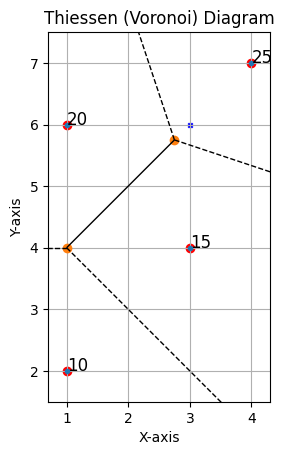

Distance from [1 2] to [3 6]: 4.47213595499958
Distance from [3 4] to [3 6]: 2.0
Distance from [1 6] to [3 6]: 2.0
Distance from [4 7] to [3 6]: 1.4142135623730951
Air quality estimate at [3 6]: 25


In [17]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

# Sample sensor locations (x, y)
sensor_locations = np.array([[1, 2], [3, 4], [1, 6], [4, 7]])

# Sample air quality values corresponding to each sensor
sensor_values = np.array([10, 15, 20, 25])

# Generate Voronoi diagram
vor = Voronoi(sensor_locations)

# Plot the Voronoi diagram
voronoi_plot_2d(vor)
plt.scatter(sensor_locations[:, 0], sensor_locations[:, 1], c='red', marker='o')

for location, value in zip(sensor_locations, sensor_values):
    plt.text(location[0], location[1], f'{value}', fontsize=12)
    
interpolation_point = np.array([3, 6])  # Point to interpolate
plt.scatter(interpolation_point[0], interpolation_point[1], c='blue', marker='x', s=10)

plt.title('Thiessen (Voronoi) Diagram')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()

# Function for Thiessen interpolation
def thiessen_interpolation(point, sensors, values):
    distances = np.linalg.norm(sensors - point, axis=1)
    
    # print distance from each point
    for sensor, distance in zip(sensors, distances):
        print(f'Distance from {sensor} to {point}: {distance}')
    
    closest_sensor_index = np.argmin(distances)
    return values[closest_sensor_index]

# Example of Thiessen interpolation
result = thiessen_interpolation(interpolation_point, sensor_locations, sensor_values)

print(f'Air quality estimate at {interpolation_point}: {result}')


In [42]:
sid = 3
tmp_ds = met_and_aq_ds.isel(station=sid).sel(time="2023-12")

tmp_df = tmp_ds.to_dataframe().reset_index()
other = "UWIND_MpS_LAY0"
# other = "U10_MpS"
print(tmp_df[["PM2.5", other]].corr())
# check lagged correlation
for shift in range(-12, 13):
    print(shift, tmp_df["PM2.5"].corr(tmp_df[other].shift(shift), method='spearman'))

                   PM2.5  UWIND_MpS_LAY0
PM2.5           1.000000       -0.432926
UWIND_MpS_LAY0 -0.432926        1.000000
-12 -0.184338051506074
-11 -0.20335978976667934
-10 -0.2194649560043445
-9 -0.23535638087053945
-8 -0.2551879219019396
-7 -0.2817828093092862
-6 -0.31725281678067235
-5 -0.36247477286677826
-4 -0.40191595236044314
-3 -0.4330273557700725
-2 -0.4522161934964162
-1 -0.4557291878669765
0 -0.4483391567324773
1 -0.42423263807539335
2 -0.38187586516414684
3 -0.3250267914696823
4 -0.26867726544548975
5 -0.2232915717617269
6 -0.19585310942204542
7 -0.1828818506664103
8 -0.18543867666941516
9 -0.19788625986911113
10 -0.21189263481680032
11 -0.22390419823093946
12 -0.2354094984132447


In [19]:
ds2d = xr.open_dataset("/home/patel_zeel/sarath_auto_download/data/camxmet2d.delhi.20230723.96hours.nc")
ds3d = xr.open_dataset("/home/patel_zeel/sarath_auto_download/data/camxmet3d.delhi.20230723.96hours.nc")
ds3d['ZGRID_M_LAY0'] = ds3d['ZGRID_M'].isel(LAY=0)
list(ds3d.data_vars)

['TFLAG',
 'ZGRID_M',
 'PRESS_MB',
 'TEMP_K',
 'HUMID_PPM',
 'UWIND_MpS',
 'VWIND_MpS',
 'ZGRID_M_LAY0']

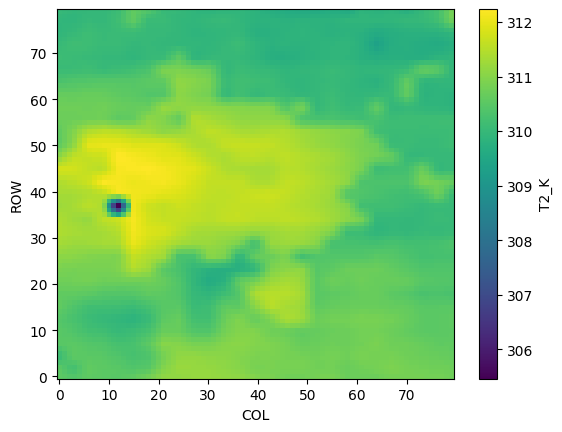

In [20]:
ds2d["T2_K"].mean(dim=["LAY"]).isel(TSTEP=10).plot()

In [21]:
ds3d

<xarray.Dataset>
Dimensions:       (TSTEP: 96, VAR: 6, DATE-TIME: 2, LAY: 20, ROW: 80, COL: 80)
Dimensions without coordinates: TSTEP, VAR, DATE-TIME, LAY, ROW, COL
Data variables:
    TFLAG         (TSTEP, VAR, DATE-TIME) int32 ...
    ZGRID_M       (TSTEP, LAY, ROW, COL) float32 ...
    PRESS_MB      (TSTEP, LAY, ROW, COL) float32 ...
    TEMP_K        (TSTEP, LAY, ROW, COL) float32 ...
    HUMID_PPM     (TSTEP, LAY, ROW, COL) float32 ...
    UWIND_MpS     (TSTEP, LAY, ROW, COL) float32 ...
    VWIND_MpS     (TSTEP, LAY, ROW, COL) float32 ...
    ZGRID_M_LAY0  (TSTEP, ROW, COL) float32 ...
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023204
    CTIME:          75422
    WDATE:          2023204
    ...             ...
    VGLVLS:         [1.   0.99 0.98 0.96 0.94 0.92 0.9  0.88 0.86 0.84 0.82 0...
    GDNAM:          ????????????????
    UPNAM:          CAMx2IOAPI      
    VAR-LIST:       ZGRID_M         PRESS_MB        TEMP_K          HUMID_PPM...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY: